### Chat with Data using Agents

In [1]:
import os
from dotenv import load_dotenv

# from langchain.agents import AgentType, initialize_agent, load_tools
# from langchain_community.llms import Ollama
from langchain_groq import ChatGroq

from langchain.schema import SystemMessage
from langchain.chains import LLMChain
from langchain.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate

from common_functions import ensure_llama_running, generate_synthetic_data, \
	display_md, extract_quotes, datasets_dir

ensure_llama_running()
load_dotenv()

# llm_model = os.getenv('LLM_MODEL')
# llm = Ollama(model=llm_model)
llm = ChatGroq(model_name=os.getenv('GROQ_SMALL_MODEL'), temperature=1.0)
data_gen_llm = ChatGroq(model_name=os.getenv('GROQ_LARGE_MODEL'), temperature=1.0)

#### Generate synthetic data

In [2]:
topic = 'sales'
fields = ['product_id', 'sales', 'date']
examples = [{ 'example': 'product_id: 1, sales: 100, dates: any dates from 2020 to 2022' }]

data_save_path = os.path.join(datasets_dir, f'{topic}_synthetic_data.csv')
df = generate_synthetic_data(data_gen_llm, topic, rows=100, fields=fields,
							examples=examples, data_save_path=data_save_path)
df.head()

,product_id,sales,date
0,1,120,2020-01-15
1,1,90,2020-02-20
2,2,150,2020-03-01
3,1,110,2020-04-10
4,3,80,2020-05-22


#### Define a chain for asking queries

In [3]:
prompt = f'''
Act as a Data Analyst and Data Scientist for a company that uses {topic} data.
Answer the user's question using the {topic} data below. Make useful text bold or italic according to the context.

```{df.to_csv(index=False)}```
'''

chatPromptTemplate = ChatPromptTemplate(
	messages = [
		SystemMessage(prompt),
		HumanMessagePromptTemplate.from_template('{question}'),
	],
	input_variables=['query_context', 'question'],
)

chain = LLMChain(
	llm=llm,
	prompt=chatPromptTemplate,
	verbose=False,
	output_key='query_answer',
)

def ask_query(query, display=False, return_quoted=False):
	response = chain.invoke(
		{ "question": query },
		output_key="query_answer",
	)
	answer = response["query_answer"]
	if return_quoted:
		return extract_quotes(answer)
	if display:
		display_md(answer)
	else:
		return answer

/home/praneeth/Desktop/AI_projects/.venv/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


In [4]:
# ask_query("What is the total sales for product 1?", display=True)

In [5]:
# ask_query("On which months are overal sales higher?", display=True)

In [6]:
# ask_query("What are the possible reasons for the drop in sales sometimes?", display=True)

#### Chatting with CSV (Similar to RAG over SQL)

INFO: Using a LocalBox which is not fully isolated
      and not scalable across multiple users.
      Make sure to use a CODEBOX_API_KEY in production.
      Set envar SHOW_INFO=False to not see this again.

AI:  Agent stopped due to iteration limit or time limit.
File:  image-8e9dfecb-1496-4fba-a982-d05fdc8fb151.png


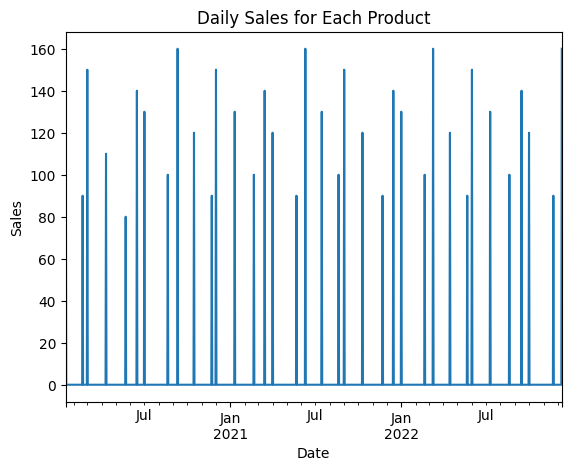

File:  image-a2706ab4-b8df-402f-8251-b955bcb7108c.png


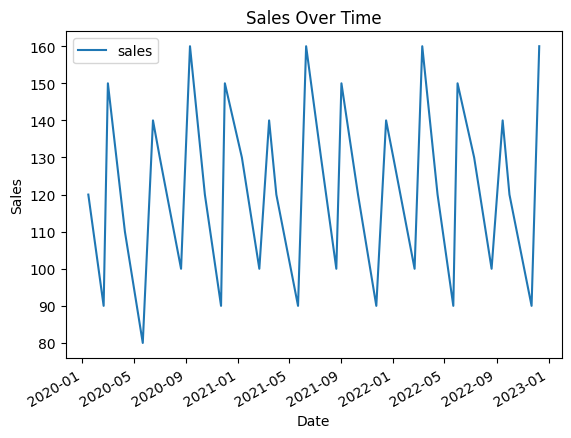

File:  image-6f85c910-0a5f-4d63-a9d5-cc5e9db74af1.png


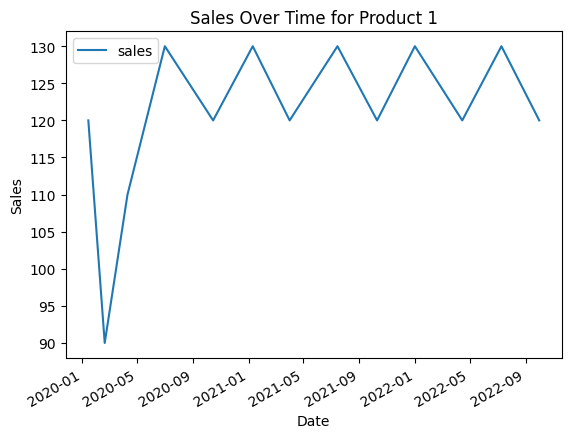

File:  image-f52d612e-30a2-4993-ad33-87dc86d4db2e.png


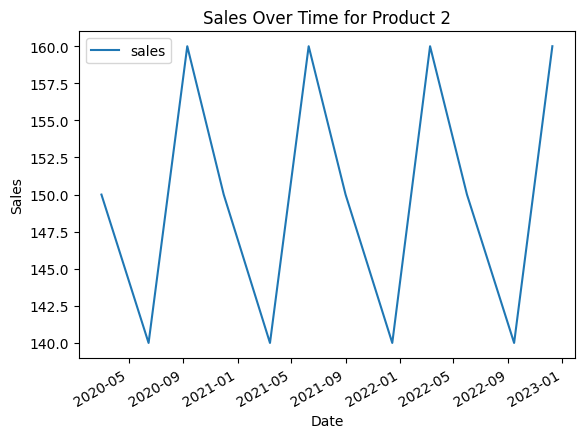

File:  image-4e940fe2-1191-4a1a-8b66-3940094d6486.png


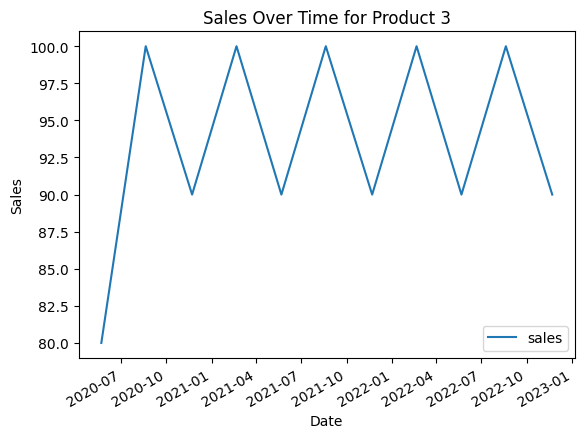

File:  image-27b93cc2-4cbb-4209-bce8-ad6cd3b9648a.png


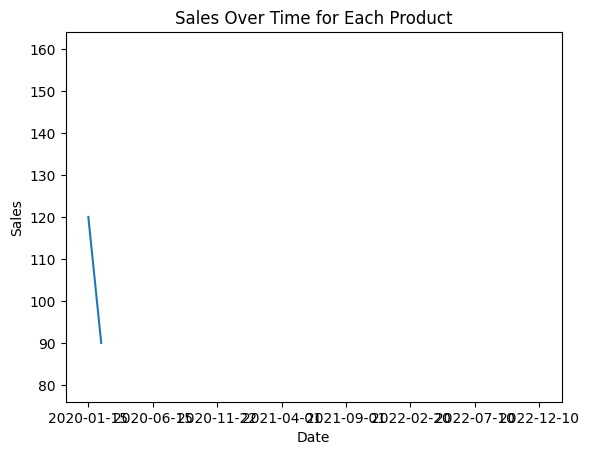

File:  image-134521b4-1ccd-44c2-b8f3-8750c25e7ba9.png


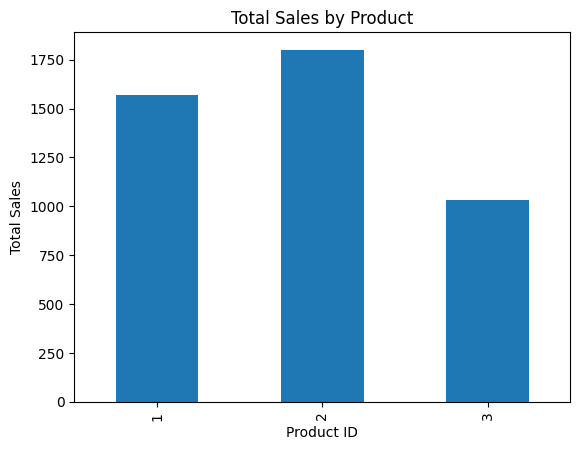

File:  image-100e2d0c-4adb-47f5-9f07-4043997979b0.png


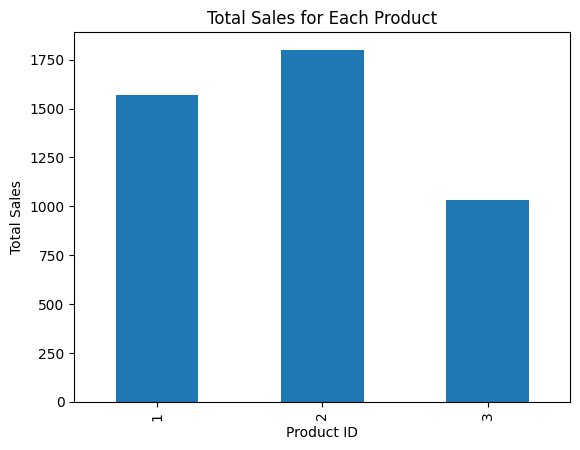

KeyboardInterrupt: 

In [9]:
# create a code interpreter agent that can execute code over the data including plotting graphs

from codeinterpreterapi import CodeInterpreterSession, File

with CodeInterpreterSession(llm) as session:
	response = session.generate_response(
		user_msg = 'Plot a graph to represent sales over the years for each product.' \
					'Use columns: ' + ', '.join(df.columns),
		files = [File.from_path(data_save_path)],
	)
	response.show()